In [6]:
import google.generativeai as genai
import json
import re
import base64
from PIL import Image
from io import BytesIO
import IPython.display

# Configure API key (Store securely in production)
GOOGLE_API_KEY = "api key"  # Replace with a valid API key
genai.configure(api_key=GOOGLE_API_KEY)

# Load and resize image
img_path = r"sample.jpg"  # Update with your image path
img = Image.open(img_path)
original_width, original_height = img.size  # Get original size before resizing
img = img.resize((800, int(800 * img.size[1] / img.size[0])), Image.Resampling.LANCZOS)
new_width, new_height = img.size  # Get new resized dimensions

# Convert image to base64
buffered = BytesIO()
img.save(buffered, format="PNG")
img_base64 = base64.b64encode(buffered.getvalue()).decode()

# Image analysis request
prompt = """
Point to no more than 10 items in the image.
The answer should follow the JSON format: [{"point": [y, x], "label": "item_name"}, ...]. 
The points should be normalized to 0-1000.
"""

response = genai.GenerativeModel(model_name="gemini-2.0-flash").generate_content(
    contents=[
        {"mime_type": "image/png", "data": img_base64},
        prompt
    ]
)

# Extract raw response text
response_text = response.candidates[0].content.parts[0].text if response.candidates else ""

# Remove markdown-style triple backticks (if present)
cleaned_text = re.sub(r"```json\n|\n```", "", response_text.strip())

try:
    # Parse JSON output
    extracted_data = json.loads(cleaned_text)

    print("Extracted Points:")
    for item in extracted_data:
        print(f"Label: {item['label']}, Point: {item['point']}")

except json.JSONDecodeError as e:
    print(f"Failed to parse response as JSON: {e}")
    extracted_data = []

# Function to generate HTML for dot visualization with proper scaling
def generate_point_html(img, points):
    img_width, img_height = img.size
    html = f'<div style="position:relative; display:inline-block;">'
    img_base64 = base64.b64encode(buffered.getvalue()).decode()
    html += f'<img src="data:image/png;base64,{img_base64}" style="width:{img_width}px;">'

    for point in points:
        y_norm, x_norm = point["point"]  # Gemini's response in normalized [y, x] format
        label = point["label"]

        # Convert normalized coordinates (0-1000) back to actual resized image dimensions
        x = int((x_norm / 1000) * img_width)  
        y = int((y_norm / 1000) * img_height)  

        html += f'''
        <div style="position:absolute; top:{y}px; left:{x}px; width:10px; height:10px; background:red; border-radius:50%;"></div>
        <div style="position:absolute; top:{y+10}px; left:{x}px; color:white; background:black; padding:2px; font-size:12px;">{label}</div>
        '''
    
    html += '</div>'
    return html

# Display the dots on the image
IPython.display.HTML(generate_point_html(img, extracted_data))


Extracted Points:
Label: curtain, Point: [94, 324]
Label: boy, Point: [152, 558]
Label: jacket, Point: [313, 637]
Label: tie, Point: [350, 537]
Label: curtain, Point: [350, 254]
Label: shoes, Point: [510, 630]
Label: curtain, Point: [562, 76]
Label: jacket, Point: [597, 484]
Label: flag, Point: [600, 686]
Label: shoes, Point: [739, 607]


## pointed image will be displayed 


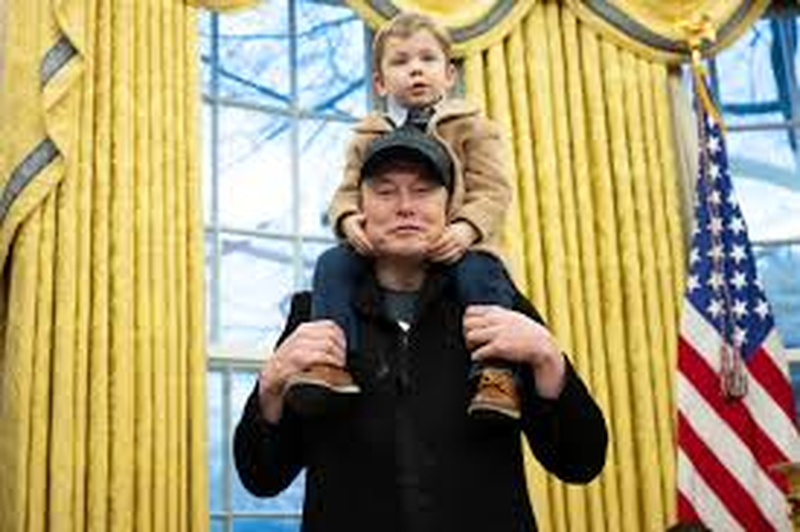

In [9]:

# Display the dots on the image
IPython.display.HTML(generate_point_html(img, extracted_data))

## some inaccurate points will be there in the image we can correct by proper html code